# **Q2**

Import the [CWRU Bearing dataset](https://engineering.case.edu/bearingdatacenter/download-data-file), and convert time series to tabular data. apply statistical feature extraction then a few preprocessing steps like [data shuffling](https://scikit-learn.org/stable/modules/generated/sklearn.utils.shuffle.html), splitting, and [normalization](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html). then design a [Logistic Regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression) for binary classification. at the end, use some metrics to validate training and test.

# Part I

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io as sio

from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

In [2]:
# Import datasets as .mat
!pip install --upgrade --no-cach-dir gdown
! gdown 1AsxhklLmPn0heWZeTbFuM9HsI8gWMNhX
! gdown 1dv1kv0J7nXO7JcVFPyuO6l-TdeDrKoRd


Usage:   
  pip3 install [options] <requirement specifier> [package-index-options] ...
  pip3 install [options] -r <requirements file> [package-index-options] ...
  pip3 install [options] [-e] <vcs project url> ...
  pip3 install [options] [-e] <local project path> ...
  pip3 install [options] <archive url/path> ...

no such option: --no-cach-dir
Downloading...
From (original): https://drive.google.com/uc?id=1AsxhklLmPn0heWZeTbFuM9HsI8gWMNhX
From (redirected): https://drive.google.com/uc?id=1AsxhklLmPn0heWZeTbFuM9HsI8gWMNhX&confirm=t&uuid=bf33c812-2c16-4688-aae7-4e4fae80b26d
To: /content/97.mat
100% 3.90M/3.90M [00:00<00:00, 152MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1dv1kv0J7nXO7JcVFPyuO6l-TdeDrKoRd
From (redirected): https://drive.google.com/uc?id=1dv1kv0J7nXO7JcVFPyuO6l-TdeDrKoRd&confirm=t&uuid=9da3f5eb-96b0-407f-b410-31df2eb13104
To: /content/105.mat
100% 2.91M/2.91M [00:00<00:00, 58.4MB/s]


In [3]:
# Extract fan end accelerometer data (FE)
data_n = sio.loadmat('97.mat')
data_f = sio.loadmat('105.mat')

data_normal = pd.DataFrame(data_n['X097_DE_time'])
data_fault = pd.DataFrame(data_f['X105_DE_time'])

# Part II

A) Convert time series to tabular dataset

In [4]:
M = 400
N = 200

X = []
Y = []

# Normal class
for i in range(M):
  start_idx = i * N
  end_idx = start_idx + N
  x = data_normal[start_idx:end_idx]
  X.append(x)
  Y.append(0) # Negative class (Normal)

# Fault class
for i in range(M):
  start_idx = i * N
  end_idx = start_idx + N
  x = data_fault[start_idx:end_idx]
  X.append(x)
  Y.append(1) # Positive class (Fault)

X = np.array(X)
Y = np.array(Y)

X = np.reshape(X,(2*M,N))
Y = np.reshape(Y,(2*M,1))

print(X.shape, Y.shape)

(800, 200) (800, 1)


B) Statictical feature extraction

In [5]:
# Square Mean Root
def smr(x):
  return np.mean(np.sqrt(abs(x)))**2

# Root Mean Square
def rms(x):
  return np.sqrt(np.mean((x**2)))

# Absolut Mean
def abs_mean(x):
  return np.mean(abs(x))

# Impact Factor 1
def IF1(x):
  return np.max(x) / (abs_mean(x))

def feature_extract(x):
  y = np.zeros((1,8))
  y[0,0] = np.mean(x)
  y[0,1] = np.std(x)
  y[0,2] = np.max(x)
  y[0,3] = np.max(x) - np.min(x)
  y[0,4] = smr(x)
  y[0,5] = rms(x)
  y[0,6] = abs_mean(x)
  y[0,7] = IF1(x)
  return y

Xnew = np.zeros(shape = (2*M,8))

for i in range(2*M):
  Xnew[[i],:] = feature_extract(X[[i],:])

C - Shuffling and splitting dataset

In [6]:
# Shuffle both X and Y with same order
X_shuffled, Y_shuffled = shuffle(Xnew,Y, random_state = 24)

In [7]:
# Split dataset
x_train , x_test , y_train , y_test = train_test_split(X_shuffled, Y_shuffled,
                                                       test_size = 0.2,
                                                       random_state = 24
                                                       )
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((640, 8), (160, 8), (640, 1), (160, 1))

 D - Normalize dataset

In [8]:
scaler = MinMaxScaler()
scaler.fit(x_train)

x_train_normalized = scaler.transform(x_train)
x_test_normalized = scaler.transform(x_test)

# Part III

A) Train model

In [9]:
# Sigmoid fucntion
def sigmoid(x):
  return 1 / (1 + np.exp(-x))

# Logistic Regression
def logreg(x,w):
  y_hat = sigmoid(x @ w)
  return y_hat

  # Binary Cross Entropy
def bce(y, y_hat):
  L = -(np.mean(y*np.log(y_hat) + (1-y)*np.log(1-y_hat)))
  return L

  # Gradient function
def gradient(x, y, y_hat):
  grad = (x.T @ (y_hat - y)) / len(y)
  return grad

# Gradient descent function
def gradient_descent(w, eta, grad):
  w -= eta * grad
  return w

In [10]:
# Add x0 as bias
x_train_normalized = np.hstack((np.ones((len(x_train_normalized),1)), x_train_normalized))
x_train_normalized.shape

(640, 9)

In [11]:
m = (Xnew.shape[1])
w = np.random.randn(m+1, 1)
eta = 0.01
n_epochs = 2000

In [12]:
# Loss function
error_hist = []

for epoch in range(n_epochs):
  # Predictions
  y_hat = logreg(x_train_normalized, w)

  # Loss
  e = bce(y_train, y_hat)
  error_hist.append(e)

  # Gradient Descent
  grads = gradient(x_train_normalized, y_train, y_hat)

  w = gradient_descent(w, eta, grads)

  if (epoch+1) % 100 == 0:
    print(f"Epoch={epoch}, \t E={e:.4}, \t w={w.T[0]}")

Epoch=99, 	 E=0.1827, 	 w=[-1.56773314 -1.61714041 -2.11145298  1.39405863  0.36996925  1.80868699
  2.20763412  0.73613225  1.68766963]
Epoch=199, 	 E=0.1663, 	 w=[-1.56724705 -1.6092412  -2.05698833  1.43697965  0.41676779  1.86110898
  2.26184671  0.78948123  1.71221391]
Epoch=299, 	 E=0.1553, 	 w=[-1.58052901 -1.60861402 -2.01233783  1.47228203  0.45543086  1.90370112
  2.30623711  0.83297278  1.73078147]
Epoch=399, 	 E=0.147, 	 w=[-1.60228116 -1.61252138 -1.97417649  1.50255181  0.48870738  1.93980809
  2.34413561  0.86995561  1.74548222]
Epoch=499, 	 E=0.1402, 	 w=[-1.62935908 -1.61934049 -1.94057429  1.52928311  0.51818765  1.97137542
  2.37747564  0.90237621  1.75754089]
Epoch=599, 	 E=0.1343, 	 w=[-1.65979049 -1.62805334 -1.91032987  1.55340316  0.54485959  1.9996154
  2.40746072  0.93144706  1.7677182 ]
Epoch=699, 	 E=0.1291, 	 w=[-1.69228947 -1.63799517 -1.88265414  1.57551995  0.56937162  2.02532445
  2.43488135  0.95796468  1.77651135]
Epoch=799, 	 E=0.1244, 	 w=[-1.725994

B) Plot loss function

Text(0, 0.5, 'error')

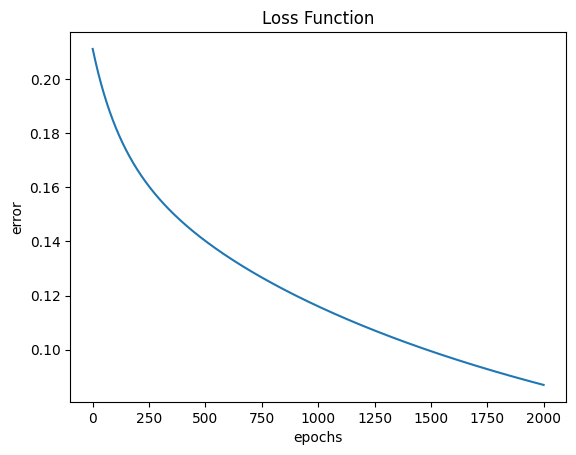

In [13]:
plt.plot(error_hist)
plt.title('Loss Function')
plt.xlabel('epochs')
plt.ylabel('error')

C) Test

In [14]:
x_test_normalized = np.hstack((np.ones((len(x_test_normalized),1)), x_test_normalized))
x_test_normalized.shape

(160, 9)

In [15]:
y_hat = logreg(x_test_normalized, w)

D) Test Metrics

In [16]:
# True Positive (TP)
def TP(actual , prediction):
    tp = 0
    for act, pred in zip(actual, np.round(prediction)):
        if act == 1 and pred == 1:
            tp +=1
    return tp

#True Negative (TN)
def TN(actual , prediction):
    tn = 0
    for act, pred in zip(actual , np.round(prediction)):
        if act == 0 and pred == 0:
            tn +=1
    return tn

#False Positive (FP)
def FP(actual , prediction):
    fp = 0
    for act, pred in zip(actual , np.round(prediction)):
        if act == 0 and pred == 1:
            fp +=1
    return fp

#False Negative (FN)
def FN(actual , prediction):
    fn = 0
    for act, pred in zip(actual , np.round(prediction)):
        if act == 1 and pred == 0:
            fn +=1
    return fn

In [17]:
# Accuracy
def accuracy(actual , prediction):
    tp = TP(actual , prediction)
    fp = FP(actual , prediction)
    fn = FN(actual , prediction)
    tn = TN(actual , prediction)
    acc_score = (tp + tn)/ (tp + tn + fp + fn)
    return acc_score

print('Accuracy of test =', accuracy(y_test, y_hat)*100,'%')

Accuracy of test = 100.0 %


In [18]:
# Precision
def precision(actual , prediction):
    tp = TP(actual , prediction)
    fp = FP(actual , prediction)
    prec = tp/ (tp + fp)
    return prec

print('Precision of test =', precision(y_test, y_hat)*100,'%')

Precision of test = 100.0 %


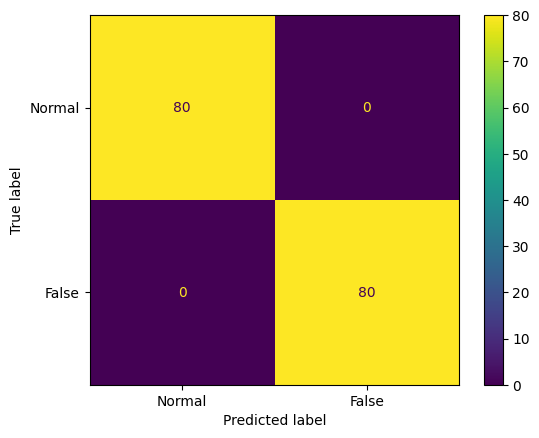

In [19]:
# Confusion matrix
confusion_matrix = metrics.confusion_matrix(y_test, np.round(y_hat))
cm_display = metrics.ConfusionMatrixDisplay(
    confusion_matrix = confusion_matrix,
    display_labels = ['Normal', 'False']
    )
cm_display.plot()
plt.show()

# Part IV

In [20]:
# Design model with default setting
clf = LogisticRegression(random_state=24)
y_train = y_train.ravel()
clf.fit(x_train_normalized, y_train)

# Check accuray
print('Accuracy of training =',clf.score(x_train_normalized, y_train)*100,'%')
print('Accuracy of test =', clf.score(x_test_normalized, y_test)*100,'%')

Accuracy of training = 100.0 %
Accuracy of test = 100.0 %
